C:\Users\sinha\AppData\Local\Temp\ipykernel_9976\2693520904.py:79: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_9976\2693520904.py:79: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_9976\2693520904.py:79: DeprecationWarning: The class ``qiski

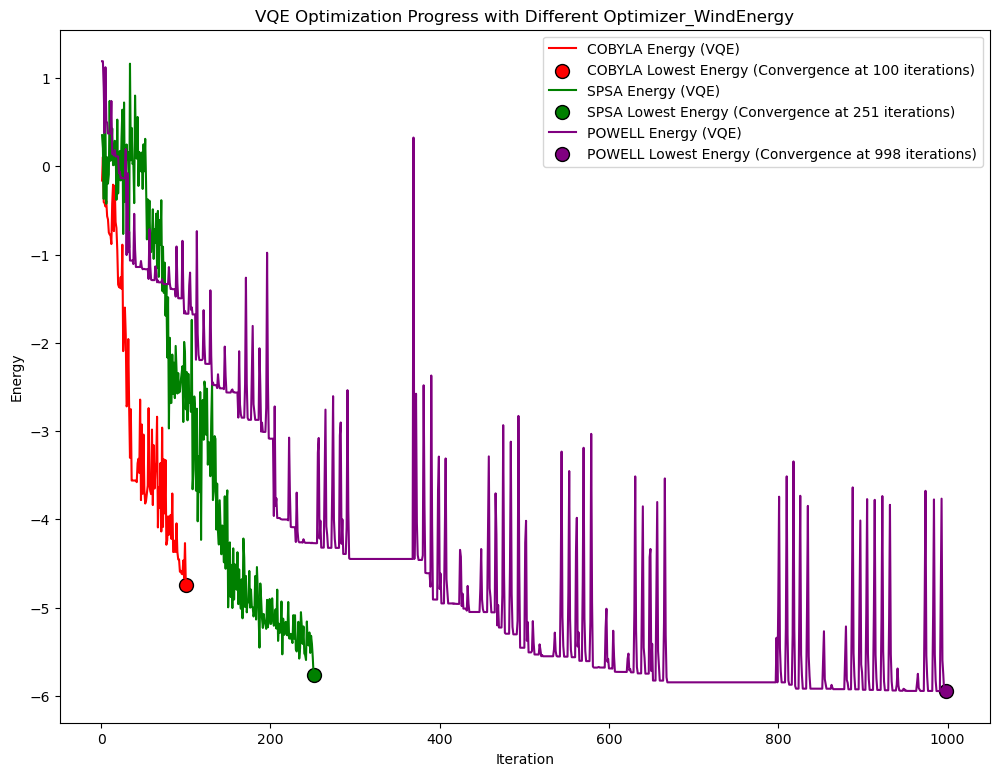

Maximized Power Output (Quantum with COBYLA): -4.739927817071534
Maximized Power Output (Quantum with SPSA): -5.767597049119584
Maximized Power Output (Quantum with POWELL): -5.947852405189588
Maximized Power Output (Classical): 0.014890998219593582

Maximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:

Optimizer: COBYLA
  Maximum Eigenvalue: 0.10676656790397271
  Reached at Iteration: 2
  Corresponding CSV Data Point: {'v': 0.6, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}

Optimizer: SPSA
  Maximum Eigenvalue: 1.1620801314457123
  Reached at Iteration: 34
  Corresponding CSV Data Point: {'v': 3.8, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}

Optimizer: POWELL
  Maximum Eigenvalue: 1.1901058325968696
  Reached at Iteration: 1
  Corresponding CSV Data Point: {'v': 0.5, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Pauli
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# Read CSV file containing values of v, H, L, D_outer, D_inner, and d
csv_file_path = "E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
v_values = data['v'].values
H_values = data['H'].values
L_values = data['L'].values
D_outer_values = data['D_outer'].values
D_inner_values = data['D_inner'].values
d_values = data['d'].values

# Constants
eta = 0.3  # Efficiency
E = 70 * 10**9  # Pascal
rho = 1.225  # kg/m^3
pi = np.pi

# Objective function to calculate power output
def power_output(v, H, L, D_outer, D_inner, d):
    numerator = (eta) * ((rho**2) * (v**5) * (D_outer**2) * (((H - (L / 2))**2) * (L**3)))
    denominator = 12 * E * ((pi / 64) * ((D_outer**4) - (D_inner**4)) * d)
    power = numerator / denominator
    return power

# Define the expanded Pauli operator based on the objective function
v_operator = SparsePauliOp.from_list([("ZIIII", 1)]) 
H_operator = SparsePauliOp.from_list([("IZIII", 1)]) 
L_operator = SparsePauliOp.from_list([("IIZII", 1)]) 
D_outer_operator = SparsePauliOp.from_list([("IIIZI", 1)]) 
D_inner_operator = SparsePauliOp.from_list([("IIIIZ", 1)]) 
d_operator = SparsePauliOp.from_list([("ZZZZZ", 1)])

# Define the interaction operator
operator = v_operator + H_operator + L_operator + D_outer_operator + D_inner_operator + d_operator

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'  # Use IBM cloud simulator backend
backend = service.backend(backend_name)

# Set options for the quantum job
options = Options(optimization_level=3)

# Visualize optimization progress
iteration_data = {}

convergence_data = {}

def callback(eval_count, parameters, mean, std, optimizer_name):
    if optimizer_name not in iteration_data:
        iteration_data[optimizer_name] = []
    iteration_data[optimizer_name].append((eval_count, mean))

    # Track the lowest energy for convergence detection
    if optimizer_name not in convergence_data:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}
    elif mean < convergence_data[optimizer_name]["lowest_energy"]:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}

# Function to run VQE with different optimizers
def run_vqe(optimizer, optimizer_name):
    iteration_data[optimizer_name] = []
    var_form = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=3, entanglement='full')
    estimator = Estimator()
    vqe_instance = VQE(estimator, var_form, optimizer, callback=lambda ec, p, m, s: callback(ec, p, m, s, optimizer_name))
    return vqe_instance.compute_minimum_eigenvalue(operator)

# Different optimizers
optimizers = {
    'COBYLA': COBYLA(maxiter=100),
    'SPSA': SPSA(maxiter=100),
    'POWELL': POWELL(options={'maxiter': 100}) 
}

# Run VQE with each optimizer
vqe_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqe_results[optimizer_name] = run_vqe(optimizer, optimizer_name)

# Plot results
colors = {'COBYLA': 'r', 'SPSA': 'g', 'POWELL': 'purple'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    iterations, energies = zip(*data)
    plt.plot(iterations, energies, label=f'{optimizer_name} Energy (VQE)', color=colors[optimizer_name])

    # Highlight lowest energy point
    lowest_energy = convergence_data[optimizer_name]["lowest_energy"]
    convergence_iteration = convergence_data[optimizer_name]["iterations_to_convergence"]
    plt.scatter(convergence_iteration, lowest_energy, color=colors[optimizer_name], marker='o', s=100, edgecolor='black',
                label=f'{optimizer_name} Lowest Energy (Convergence at {convergence_iteration} iterations)')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Optimization Progress with Different Optimizer_WindEnergy')
plt.legend()
plt.savefig("vqe_optimization_progress_wind1o3.svg",  dpi=300)  # Save the figure as a SVG file
plt.show()

# Classical comparison
classical_power_outputs = []
for v, H, L, D_outer, D_inner, d in zip(v_values, H_values, L_values, D_outer_values, D_inner_values, d_values):
    classical_power_outputs.append(power_output(v, H, L, D_outer, D_inner, d))

# Print the final outputs
for optimizer_name, result in vqe_results.items():
    quantum_max_power_output = result.eigenvalue.real
    print(f"Maximized Power Output (Quantum with {optimizer_name}): {quantum_max_power_output}")

print("Maximized Power Output (Classical):", max(classical_power_outputs))
csv_data = pd.read_csv("E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv")

print("\nMaximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:")

# Iterate through each optimizer's data
for optimizer_name, data in iteration_data.items():
    iterations, eigenvalues = zip(*data)  # Unpack iterations and eigenvalues
    local_max_eigenvalue = max(eigenvalues)
    local_max_iteration = iterations[eigenvalues.index(local_max_eigenvalue)]
    
    # Map the maximum eigenvalue to the corresponding CSV row
    csv_row_index = local_max_iteration - 1  # Adjust for 0-based indexing
    
    print(f"\nOptimizer: {optimizer_name}")
    print(f"  Maximum Eigenvalue: {local_max_eigenvalue}")
    print(f"  Reached at Iteration: {local_max_iteration}")
    
    if isinstance(csv_data, list):
        # Handle csv_data as a list of rows
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    elif isinstance(csv_data, pd.DataFrame):
        # Handle csv_data as a pandas DataFrame
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data.iloc[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row.to_dict()}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    else:
        print("  Unknown CSV Data Format!")



C:\Users\sinha\AppData\Local\Temp\ipykernel_9976\744850645.py:77: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_9976\744850645.py:77: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_9976\744850645.py:77: DeprecationWarning: The class ``qiskit.p

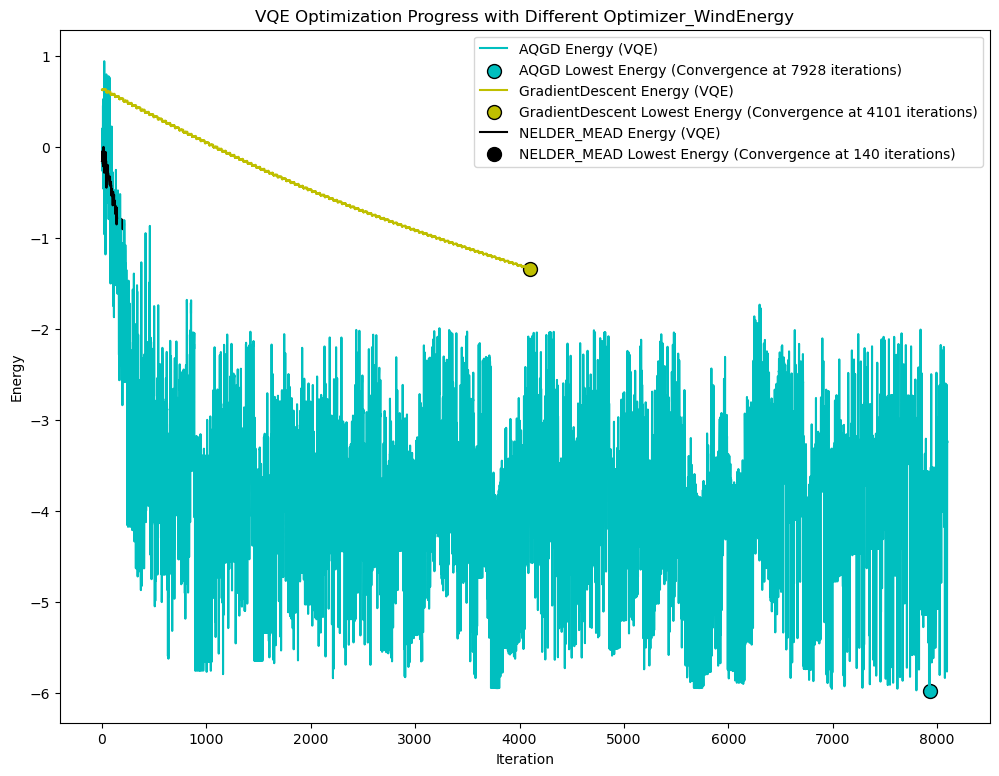

Maximized Power Output (Quantum with AQGD): -3.2377898431295873
Maximized Power Output (Quantum with GradientDescent): -1.3460383524340984
Maximized Power Output (Quantum with NELDER_MEAD): -0.8521597156710811
Maximized Power Output (Classical): 0.014890998219593582

Maximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:

Optimizer: AQGD
  Maximum Eigenvalue: 0.9399265341308751
  Reached at Iteration: 22
  Corresponding CSV Data Point: {'v': 2.6, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}

Optimizer: GradientDescent
  Maximum Eigenvalue: 0.6329442561449317
  Reached at Iteration: 35
  Corresponding CSV Data Point: {'v': 3.9, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}

Optimizer: NELDER_MEAD
  Maximum Eigenvalue: -0.0008457002018736892
  Reached at Iteration: 15
  Corresponding CSV Data Point: {'v': 1.9, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import AQGD, GradientDescent, NELDER_MEAD
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Pauli
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# Read CSV file containing values of v, H, L, D_outer, D_inner, and d
csv_file_path = "E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
v_values = data['v'].values
H_values = data['H'].values
L_values = data['L'].values
D_outer_values = data['D_outer'].values
D_inner_values = data['D_inner'].values
d_values = data['d'].values

# Constants
eta = 0.3  # Efficiency
E = 70 * 10**9  # Pascal
rho = 1.225  # kg/m^3
pi = np.pi

# Objective function to calculate power output
def power_output(v, H, L, D_outer, D_inner, d):
    numerator = (eta) * ((rho**2) * (v**5) * (D_outer**2) * (((H - (L / 2))**2) * (L**3)))
    denominator = 12 * E * ((pi / 64) * ((D_outer**4) - (D_inner**4)) * d)
    power = numerator / denominator
    return power

# Define the expanded Pauli operator based on the objective function
v_operator = SparsePauliOp.from_list([("ZIIII", 1)]) 
H_operator = SparsePauliOp.from_list([("IZIII", 1)]) 
L_operator = SparsePauliOp.from_list([("IIZII", 1)]) 
D_outer_operator = SparsePauliOp.from_list([("IIIZI", 1)]) 
D_inner_operator = SparsePauliOp.from_list([("IIIIZ", 1)]) 
d_operator = SparsePauliOp.from_list([("ZZZZZ", 1)])

# Define the interaction operator
operator = v_operator + H_operator + L_operator + D_outer_operator + D_inner_operator + d_operator

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'  # Use IBM cloud simulator backend
backend = service.backend(backend_name)

# Set options for the quantum job
options = Options(optimization_level=3)

# Visualize optimization progress
iteration_data = {}
convergence_data = {}
def callback(eval_count, parameters, mean, std, optimizer_name):
    if optimizer_name not in iteration_data:
        iteration_data[optimizer_name] = []
    iteration_data[optimizer_name].append((eval_count, mean))

    # Track the lowest energy for convergence detection
    if optimizer_name not in convergence_data:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}
    elif mean < convergence_data[optimizer_name]["lowest_energy"]:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}

# Function to run VQE with different optimizers
def run_vqe(optimizer, optimizer_name):
    iteration_data[optimizer_name] = []
    var_form = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=3, entanglement='full')
    estimator = Estimator()
    vqe_instance = VQE(estimator, var_form, optimizer, callback=lambda ec, p, m, s: callback(ec, p, m, s, optimizer_name))
    return vqe_instance.compute_minimum_eigenvalue(operator)

# Different optimizers
optimizers = {
    'AQGD': AQGD(maxiter=100),
    'GradientDescent': GradientDescent(maxiter=100),
    'NELDER_MEAD': NELDER_MEAD(maxiter=100) 
}

# Run VQE with each optimizer
vqe_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqe_results[optimizer_name] = run_vqe(optimizer, optimizer_name)

# Plot results
colors = {'AQGD': 'c', 'GradientDescent': 'y', 'NELDER_MEAD': 'k'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    iterations, energies = zip(*data)
    plt.plot(iterations, energies, label=f'{optimizer_name} Energy (VQE)', color=colors[optimizer_name])

    # Highlight lowest energy point
    lowest_energy = convergence_data[optimizer_name]["lowest_energy"]
    convergence_iteration = convergence_data[optimizer_name]["iterations_to_convergence"]
    plt.scatter(convergence_iteration, lowest_energy, color=colors[optimizer_name], marker='o', s=100, edgecolor='black',
                label=f'{optimizer_name} Lowest Energy (Convergence at {convergence_iteration} iterations)')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Optimization Progress with Different Optimizer_WindEnergy')
plt.legend()
plt.savefig("vqe_optimization_progress_wind2o3.svg",  dpi=300)  # Save the figure as a SVG file
plt.show()

# Classical comparison
classical_power_outputs = []
for v, H, L, D_outer, D_inner, d in zip(v_values, H_values, L_values, D_outer_values, D_inner_values, d_values):
    classical_power_outputs.append(power_output(v, H, L, D_outer, D_inner, d))

# Print the final outputs
for optimizer_name, result in vqe_results.items():
    quantum_max_power_output = result.eigenvalue.real
    print(f"Maximized Power Output (Quantum with {optimizer_name}): {quantum_max_power_output}")

print("Maximized Power Output (Classical):", max(classical_power_outputs))
csv_data = pd.read_csv("E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv")

print("\nMaximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:")

# Iterate through each optimizer's data
for optimizer_name, data in iteration_data.items():
    iterations, eigenvalues = zip(*data)  # Unpack iterations and eigenvalues
    local_max_eigenvalue = max(eigenvalues)
    local_max_iteration = iterations[eigenvalues.index(local_max_eigenvalue)]
    
    # Map the maximum eigenvalue to the corresponding CSV row
    csv_row_index = local_max_iteration - 1  # Adjust for 0-based indexing
    
    print(f"\nOptimizer: {optimizer_name}")
    print(f"  Maximum Eigenvalue: {local_max_eigenvalue}")
    print(f"  Reached at Iteration: {local_max_iteration}")
    
    if isinstance(csv_data, list):
        # Handle csv_data as a list of rows
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    elif isinstance(csv_data, pd.DataFrame):
        # Handle csv_data as a pandas DataFrame
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data.iloc[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row.to_dict()}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    else:
        print("  Unknown CSV Data Format!")



C:\Users\sinha\AppData\Local\Temp\ipykernel_9976\3876482891.py:77: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_9976\3876482891.py:77: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_9976\3876482891.py:77: DeprecationWarning: The class ``qiski

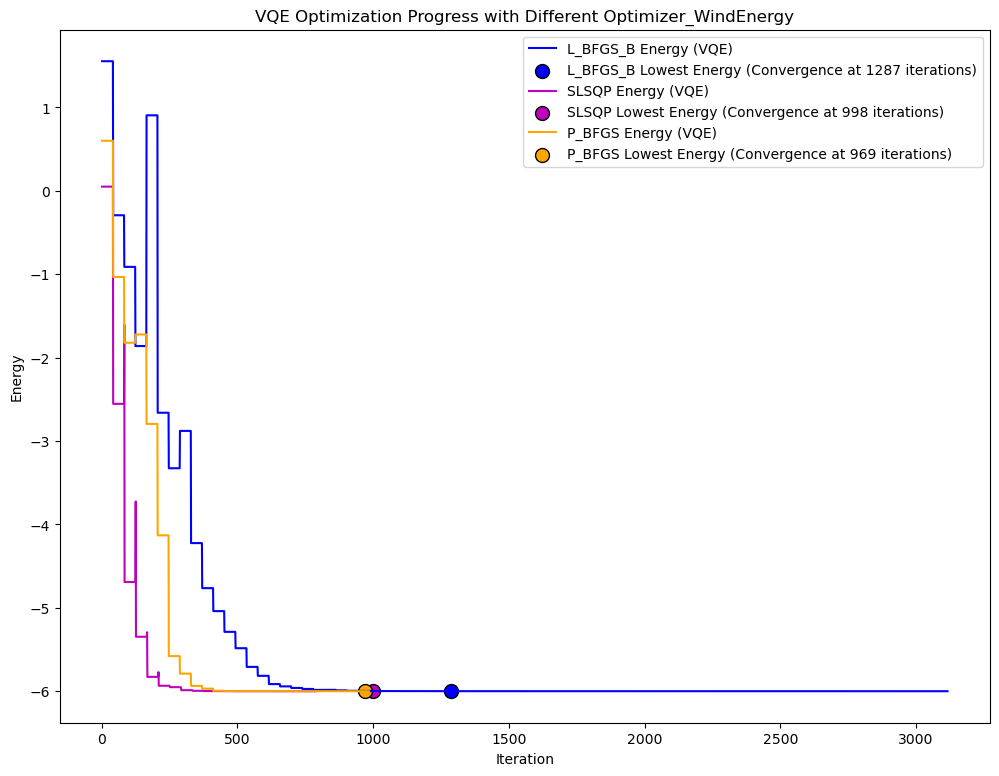

Maximized Power Output (Quantum with L_BFGS_B): -5.999999994496587
Maximized Power Output (Quantum with SLSQP): -5.999999422222157
Maximized Power Output (Quantum with P_BFGS): -5.99999999995907
Maximized Power Output (Classical): 0.014890998219593582

Maximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:

Optimizer: L_BFGS_B
  Maximum Eigenvalue: 1.5543232748034495
  Reached at Iteration: 35
  Corresponding CSV Data Point: {'v': 3.9, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}

Optimizer: SLSQP
  Maximum Eigenvalue: 0.05048738304596482
  Reached at Iteration: 2
  Corresponding CSV Data Point: {'v': 0.6, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}

Optimizer: P_BFGS
  Maximum Eigenvalue: 0.600698778095166
  Reached at Iteration: 8
  Corresponding CSV Data Point: {'v': 1.2, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import L_BFGS_B, SLSQP, P_BFGS
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Pauli
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# Read CSV file containing values of v, H, L, D_outer, D_inner, and d
csv_file_path = "E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
v_values = data['v'].values
H_values = data['H'].values
L_values = data['L'].values
D_outer_values = data['D_outer'].values
D_inner_values = data['D_inner'].values
d_values = data['d'].values

# Constants
eta = 0.3  # Efficiency
E = 70 * 10**9  # Pascal
rho = 1.225  # kg/m^3
pi = np.pi

# Objective function to calculate power output
def power_output(v, H, L, D_outer, D_inner, d):
    numerator = (eta) * ((rho**2) * (v**5) * (D_outer**2) * (((H - (L / 2))**2) * (L**3)))
    denominator = 12 * E * ((pi / 64) * ((D_outer**4) - (D_inner**4)) * d)
    power = numerator / denominator
    return power

# Define the expanded Pauli operator based on the objective function
v_operator = SparsePauliOp.from_list([("ZIIII", 1)]) 
H_operator = SparsePauliOp.from_list([("IZIII", 1)]) 
L_operator = SparsePauliOp.from_list([("IIZII", 1)]) 
D_outer_operator = SparsePauliOp.from_list([("IIIZI", 1)]) 
D_inner_operator = SparsePauliOp.from_list([("IIIIZ", 1)]) 
d_operator = SparsePauliOp.from_list([("ZZZZZ", 1)])

# Define the interaction operator
operator = v_operator + H_operator + L_operator + D_outer_operator + D_inner_operator + d_operator

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'  # Use IBM cloud simulator backend
backend = service.backend(backend_name)

# Set options for the quantum job
options = Options(optimization_level=3)

# Visualize optimization progress
iteration_data = {}
convergence_data = {}
def callback(eval_count, parameters, mean, std, optimizer_name):
    if optimizer_name not in iteration_data:
        iteration_data[optimizer_name] = []
    iteration_data[optimizer_name].append((eval_count, mean))

    # Track the lowest energy for convergence detection
    if optimizer_name not in convergence_data:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}
    elif mean < convergence_data[optimizer_name]["lowest_energy"]:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}

# Function to run VQE with different optimizers
def run_vqe(optimizer, optimizer_name):
    iteration_data[optimizer_name] = []
    var_form = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=3, entanglement='full')
    estimator = Estimator()
    vqe_instance = VQE(estimator, var_form, optimizer, callback=lambda ec, p, m, s: callback(ec, p, m, s, optimizer_name))
    return vqe_instance.compute_minimum_eigenvalue(operator)

# Different optimizers
optimizers = {
    'L_BFGS_B': L_BFGS_B(maxiter=100),
    'SLSQP': SLSQP(maxiter=100),
    'P_BFGS': P_BFGS(options={'maxiter': 100}) 
}

# Run VQE with each optimizer
vqe_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqe_results[optimizer_name] = run_vqe(optimizer, optimizer_name)

# Plot results
colors = {'L_BFGS_B': 'b', 'SLSQP': 'm', 'P_BFGS': 'orange'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    iterations, energies = zip(*data)
    plt.plot(iterations, energies, label=f'{optimizer_name} Energy (VQE)', color=colors[optimizer_name])
     # Highlight lowest energy point
    lowest_energy = convergence_data[optimizer_name]["lowest_energy"]
    convergence_iteration = convergence_data[optimizer_name]["iterations_to_convergence"]
    plt.scatter(convergence_iteration, lowest_energy, color=colors[optimizer_name], marker='o', s=100, edgecolor='black',
                label=f'{optimizer_name} Lowest Energy (Convergence at {convergence_iteration} iterations)')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Optimization Progress with Different Optimizer_WindEnergy')
plt.legend()
plt.savefig("vqe_optimization_progress_wind3o3.svg",  dpi=300)  # Save the figure as a SVG file
plt.show()

# Classical comparison
classical_power_outputs = []
for v, H, L, D_outer, D_inner, d in zip(v_values, H_values, L_values, D_outer_values, D_inner_values, d_values):
    classical_power_outputs.append(power_output(v, H, L, D_outer, D_inner, d))

# Print the final outputs
for optimizer_name, result in vqe_results.items():
    quantum_max_power_output = result.eigenvalue.real
    print(f"Maximized Power Output (Quantum with {optimizer_name}): {quantum_max_power_output}")

print("Maximized Power Output (Classical):", max(classical_power_outputs))
csv_data = pd.read_csv("E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv")

print("\nMaximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:")

# Iterate through each optimizer's data
for optimizer_name, data in iteration_data.items():
    iterations, eigenvalues = zip(*data)  # Unpack iterations and eigenvalues
    local_max_eigenvalue = max(eigenvalues)
    local_max_iteration = iterations[eigenvalues.index(local_max_eigenvalue)]
    
    # Map the maximum eigenvalue to the corresponding CSV row
    csv_row_index = local_max_iteration - 1  # Adjust for 0-based indexing
    
    print(f"\nOptimizer: {optimizer_name}")
    print(f"  Maximum Eigenvalue: {local_max_eigenvalue}")
    print(f"  Reached at Iteration: {local_max_iteration}")
    
    if isinstance(csv_data, list):
        # Handle csv_data as a list of rows
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    elif isinstance(csv_data, pd.DataFrame):
        # Handle csv_data as a pandas DataFrame
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data.iloc[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row.to_dict()}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    else:
        print("  Unknown CSV Data Format!")

